In [1]:
import numpy as np
import pandas as pd
from river import optim
from river import metrics
from river.drift.binary import EDDM
from sail.telemetry import TracingClient
from sail.models.auto_ml.tune import SAILTuneGridSearchCV
from sail.models.river.forest import AdaptiveRandomForestClassifier
from sail.models.river.linear_model import LogisticRegression
from sail.models.keras import KerasSequentialClassifier
from sail.models.auto_ml.auto_pipeline import SAILAutoPipeline
from sail.pipeline import SAILPipeline
from sklearn.impute import SimpleImputer
from sail.drift_detection.drift_detector import SAILDriftDetector
from sail.transformers.river.preprocessing import StandardScaler

#### Load Data


In [2]:
X = pd.read_csv("../../datasets/agrawal.csv").head(50000)

y = X["class"]
X.drop("class", axis=1, inplace=True)

#### Model Definition


In [3]:
logistic_reg = LogisticRegression(optimizer=optim.SGD(0.1))
random_forest = AdaptiveRandomForestClassifier(n_models=10)
keras = KerasSequentialClassifier(
    num_hidden_nodes=[10],
    hidden_layer_activation=["relu"],
    num_output_nodes=1,
    outer_layer_activation="sigmoid",
)

#### Create SAIL Pipeline


In [4]:
steps = [
    ("Imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
    ("standard_scalar", StandardScaler()),
    ("classifier", "passthrough"),
]
sail_pipeline = SAILPipeline(
    steps=steps, scoring=[metrics.Accuracy], verbosity_level=1, verbosity_interval=1
)

#### HPO Params


In [5]:
params_grid = [
    {
        "classifier": [logistic_reg],
        "classifier__l2": [0.1, 0.9],
        "classifier__intercept_init": [0.2, 0.5],
    },
    {
        "classifier": [random_forest],
        "classifier__n_models": [5, 10],
        "Imputer": ["passthrough"],
    },
    {"classifier": [keras], "classifier__num_hidden_nodes": [[5], [10]]},
]

#### Create Model Instance


In [6]:
tracer = TracingClient(
    service_name="SAILAutoPipeline-Classification",
    otlp_endpoint="http://83.212.75.52:31318",
)

auto_pipeline = SAILAutoPipeline(
    pipeline=sail_pipeline,
    pipeline_params_grid=params_grid,
    search_method=SAILTuneGridSearchCV,
    search_method_params={
        "num_cpus_per_trial": 1,
        "max_iters": 1,
        "early_stopping": False,
        "mode": "max",
        "scoring": "accuracy",
        "pipeline_auto_early_stop": False,
        "keep_best_configurations": 2,
    },
    search_data_size=1000,
    incremental_training=True,
    drift_detector=SAILDriftDetector(model=EDDM(), drift_param="score"),
    pipeline_strategy="DetectAndIncrement",
    verbosity_level=1,
    verbosity_interval=1,
    tensorboard_log_dir="/Users/dhaval/Projects/Tensorboard_logs",
    tracer=tracer,
)

[2023-12-15 17:40:07:494] - INFO - SAIL (PipelineStrategy) - Pipeline Strategy [DetectAndIncrement] created with actions: ['DATA_COLLECTION', 'FIND_BEST_PIPELINE', 'SCORE_AND_DETECT_DRIFT', 'PARTIAL_FIT_MODEL']


#### Start Training


In [7]:
y_preds = []
y_true = []
batch_size = 50

with tracer.trace_as_current_span(span_name="Pipeline-Train"):
    for start in range(0, 2000, batch_size):
        end = start + batch_size

        X_train = X.iloc[start:end]
        y_train = y.iloc[start:end]

        if start == 0:
            keras.fit(X_train, y_train)

        if end > 1000:  # search_data_size is 1000
            preds = auto_pipeline.predict(X_train)
            if preds is not None:
                y_preds.extend(list(preds))
                y_true.extend(list(y_train))

        auto_pipeline.train(X_train, y_train, classifier__classes=[1, 0])

INFO:tensorflow:Assets written to: ram://2831d841267b4541aeb94328912a33e8/assets


INFO:tensorflow:Assets written to: ram://2831d841267b4541aeb94328912a33e8/assets


INFO:tensorflow:Assets written to: ram://da088f5f74aa4768a7c3c3a9948caa8d/assets


INFO:tensorflow:Assets written to: ram://da088f5f74aa4768a7c3c3a9948caa8d/assets
2023-12-15 12:49:03.892371: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://bdc9cae1fa5a4c65bb5cfb02446307b5: INVALID_ARGUMENT: ram://bdc9cae1fa5a4c65bb5cfb02446307b5 is a directory.


INFO:tensorflow:Assets written to: ram://a87b7422eb7b4629af07fec614a9c72a/assets


INFO:tensorflow:Assets written to: ram://a87b7422eb7b4629af07fec614a9c72a/assets
2023-12-15 12:49:04.403792: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://db4fd4554a714ff691d670fb300d7fe9: INVALID_ARGUMENT: ram://db4fd4554a714ff691d670fb300d7fe9 is a directory.


INFO:tensorflow:Assets written to: ram://dea6ed8dfa674bc48db26f5a3677b1fb/assets


INFO:tensorflow:Assets written to: ram://dea6ed8dfa674bc48db26f5a3677b1fb/assets
2023-12-15 12:49:05.006645: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://ee98551a49f640a5be8320317eccaeca: INVALID_ARGUMENT: ram://ee98551a49f640a5be8320317eccaeca is a directory.


INFO:tensorflow:Assets written to: ram://903e472905594cc58e2e7f99e76f5f5c/assets


INFO:tensorflow:Assets written to: ram://903e472905594cc58e2e7f99e76f5f5c/assets


INFO:tensorflow:Assets written to: ram://1784b02dce4749ca9c106ac0ab67e01f/assets


INFO:tensorflow:Assets written to: ram://1784b02dce4749ca9c106ac0ab67e01f/assets
2023-12-15 12:49:06.712500: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2520d30015ed45fc915d7f3ef045daea: INVALID_ARGUMENT: ram://2520d30015ed45fc915d7f3ef045daea is a directory.


INFO:tensorflow:Assets written to: ram://f9c803c3a487463da2e98bca63b87ad7/assets


INFO:tensorflow:Assets written to: ram://f9c803c3a487463da2e98bca63b87ad7/assets


INFO:tensorflow:Assets written to: ram://bca2dd336a184b49b3ced3caf7d17397/assets


INFO:tensorflow:Assets written to: ram://bca2dd336a184b49b3ced3caf7d17397/assets


INFO:tensorflow:Assets written to: ram://0f75c5cfb2a242879b31f3b110919481/assets


INFO:tensorflow:Assets written to: ram://0f75c5cfb2a242879b31f3b110919481/assets
(_Trainable pid=89286) 2023-12-15 12:49:09.383291: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://a7378daff262450eb54e6b68bf910657: INVALID_ARGUMENT: ram://a7378daff262450eb54e6b68bf910657 is a directory.


INFO:tensorflow:Assets written to: ram://c586081fe31b44d09f5c4cf2f8cedd51/assets


(_Trainable pid=89286) WARNING:absl:Found untraced functions such as _update_step_xla while saving (showing 1 of 1). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: ram://c586081fe31b44d09f5c4cf2f8cedd51/assets


INFO:tensorflow:Assets written to: ram://73a72312ded14e88a6ae6b6d62dbd627/assets


INFO:tensorflow:Assets written to: ram://73a72312ded14e88a6ae6b6d62dbd627/assets


INFO:tensorflow:Assets written to: ram://33cc1f7e44fb4628a26501d2d97f58e8/assets


INFO:tensorflow:Assets written to: ram://33cc1f7e44fb4628a26501d2d97f58e8/assets


INFO:tensorflow:Assets written to: ram://3cb08f77cb1946639d1eb16da1e23255/assets


(_Trainable pid=89255) 2023-12-15 12:49:10.636002: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
INFO:tensorflow:Assets written to: ram://3cb08f77cb1946639d1eb16da1e23255/assets
2023-12-15 12:49:11.162241: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://613a63c7eaa24f96af9106d342aa18af: INVALID_ARGUMENT: ram://613a63c7eaa24f96af9106d342aa18af is a directory.


INFO:tensorflow:Assets written to: ram://6298ce1f1fea47ddabc42307bdab86bb/assets


INFO:tensorflow:Assets written to: ram://6298ce1f1fea47ddabc42307bdab86bb/assets
2023-12-15 12:49:11.689596: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://5391e0813254419ba8239b02da4adb51: INVALID_ARGUMENT: ram://5391e0813254419ba8239b02da4adb51 is a directory.


INFO:tensorflow:Assets written to: ram://1108d28392314ba4b312342007dd5dc0/assets


INFO:tensorflow:Assets written to: ram://1108d28392314ba4b312342007dd5dc0/assets
2023-12-15 12:49:12.319049: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://33752d7ec4e0440bacaac081218fcb1c: INVALID_ARGUMENT: ram://33752d7ec4e0440bacaac081218fcb1c is a directory.


INFO:tensorflow:Assets written to: ram://78374a67698a4bc48cbfca66f321207e/assets


INFO:tensorflow:Assets written to: ram://78374a67698a4bc48cbfca66f321207e/assets


2023-12-15 12:49:13.113170: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://1d4f72c89a8e4c5fbb2ea539192215e3: INVALID_ARGUMENT: ram://1d4f72c89a8e4c5fbb2ea539192215e3 is a directory.


INFO:tensorflow:Assets written to: ram://2df14e92d8cb495ab59cfa9af44bd623/assets


INFO:tensorflow:Assets written to: ram://2df14e92d8cb495ab59cfa9af44bd623/assets
2023-12-15 12:49:13.617145: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://308679d48ded4178b013a5a3ec3d3880: INVALID_ARGUMENT: ram://308679d48ded4178b013a5a3ec3d3880 is a directory.


INFO:tensorflow:Assets written to: ram://0a1978e3072542f7bfa7c99624ab710e/assets


INFO:tensorflow:Assets written to: ram://0a1978e3072542f7bfa7c99624ab710e/assets


INFO:tensorflow:Assets written to: ram://9e782a0517914e199e320e3c0687d1f7/assets


(_Trainable pid=89255) 2023-12-15 12:49:14.276643: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://2e388a97f2414c13b8a42e66dac8131d: INVALID_ARGUMENT: ram://2e388a97f2414c13b8a42e66dac8131d is a directory. [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
INFO:tensorflow:Assets written to: ram://9e782a0517914e199e320e3c0687d1f7/assets
2023-12-15 12:49:15.412849: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://aaeb218a02974e8a958684acda5cdf12: INVALID_ARGUMENT: ram://aaeb218a02974e8a958684acda5cdf12 is a directory.
(_Trainable pid=89255) WARNING:absl:Found untraced functions such as _update_step_xla while saving (showing 1 of 1). These functions will not be directly callable after loading. [repeated 4x across cluster]
(_Trainable pid=89255) WARNING:tensorflow:Detecting t

2023-12-15 12:49:17.386835: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://c0bd5adc149f43458d31fc799ec8b731: INVALID_ARGUMENT: ram://c0bd5adc149f43458d31fc799ec8b731 is a directory.


INFO:tensorflow:Assets written to: ram://dfa3a0eb34be482ea2415094c81dcbe7/assets


INFO:tensorflow:Assets written to: ram://dfa3a0eb34be482ea2415094c81dcbe7/assets


INFO:tensorflow:Assets written to: ram://3b5a4057c4684d0c8bf8114e7cd25095/assets


INFO:tensorflow:Assets written to: ram://3b5a4057c4684d0c8bf8114e7cd25095/assets


INFO:tensorflow:Assets written to: ram://59ca7f1c7f2f4096b167606d53ae2b91/assets


INFO:tensorflow:Assets written to: ram://59ca7f1c7f2f4096b167606d53ae2b91/assets


INFO:tensorflow:Assets written to: ram://3f9d4b66efbf4f6e98093bba68e0be48/assets


INFO:tensorflow:Assets written to: ram://3f9d4b66efbf4f6e98093bba68e0be48/assets


INFO:tensorflow:Assets written to: ram://da4bda6e86514ed68683a8018a28ce04/assets


INFO:tensorflow:Assets written to: ram://da4bda6e86514ed68683a8018a28ce04/assets


INFO:tensorflow:Assets written to: ram://0d3bb9c7c8c6483893d16eb8b31a6ce0/assets


INFO:tensorflow:Assets written to: ram://0d3bb9c7c8c6483893d16eb8b31a6ce0/assets


INFO:tensorflow:Assets written to: ram://f45da5c469fb47bd89699a4c2a554145/assets


INFO:tensorflow:Assets written to: ram://f45da5c469fb47bd89699a4c2a554145/assets


INFO:tensorflow:Assets written to: ram://6ca00b3f11554f3da051830aa450ccda/assets


INFO:tensorflow:Assets written to: ram://6ca00b3f11554f3da051830aa450ccda/assets
INFO:ray.tune.tune:Total run time: 22.36 seconds (19.35 seconds for the tuning loop).
(_Trainable pid=89296) 2023-12-15 12:49:17.118429: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://89622cf5bcb345ce819fa4fcc0fdfe41: INVALID_ARGUMENT: ram://89622cf5bcb345ce819fa4fcc0fdfe41 is a directory. [repeated 2x across cluster]
(_Trainable pid=89296) WARNING:absl:Found untraced functions such as _update_step_xla while saving (showing 1 of 1). These functions will not be directly callable after loading. [repeated 2x across cluster]
[2023-12-15 12:49:22:218] - INFO - SAIL (PipelineStrategy) - Pipeline tuning completed. Disconnecting Ray cluster...
[2023-12-15 12:49:22:220] - INFO - SAIL (PipelineStrategy) - Found best params: {'Imputer': 'passthrough', 'classifier': AdaptiveRandomForestClassifier(drift_detector=ADWIN (
      delta=0.001
      clock=32
      max_buckets=5
      min_window_length

#### Save model


In [8]:
auto_pipeline.save_model(".")

[2023-12-15 12:49:28:234] - INFO - SAIL (SAILModel) - Model saved successfully.


INFO:tensorflow:Assets written to: ram://89350bb14afb4fd991e7ec0813a9e3d0/assets


INFO:tensorflow:Assets written to: ram://89350bb14afb4fd991e7ec0813a9e3d0/assets


'./sail_auto_pipeline'

#### Load model


In [9]:
new_auto_pipeline = SAILAutoPipeline.load_model(".")

2023-12-15 12:49:29.040991: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ram://d035461e3cd548518b15b246bf1b5a6e: INVALID_ARGUMENT: ram://d035461e3cd548518b15b246bf1b5a6e is a directory.
[2023-12-15 12:49:29:49] - INFO - SAIL (PipelineStrategy) - Pipeline Strategy [DetectAndIncrement] created with actions: ['DATA_COLLECTION', 'FIND_BEST_PIPELINE', 'SCORE_AND_DETECT_DRIFT', 'PARTIAL_FIT_MODEL']
[2023-12-15 12:49:29:51] - INFO - SAIL (TensorboardWriter) - Sending training output to Tensorboard logs. Please run `tensorboard --logdir /Users/dhaval/Projects/Tensorboard_logs/Training_Logs` in terminal to start tensorboard server and track training progress.
[2023-12-15 12:49:29:96] - INFO - SAIL (SAILModel) - Model loaded successfully.
SAIL Pipeline Progressive Score: 100%========== [Points: 2000/2000, Elapsed:0.0045s, Metric=Accuracy, Batch Size=2000, P_Score=0.885]


#### Continue training using the load model


In [10]:
for start in range(1501, 3001, batch_size):
    end = start + batch_size

    X_train = X.iloc[start:end]
    y_train = y.iloc[start:end]

    if end > 1000:  # search_data_size is 1000
        preds = new_auto_pipeline.predict(X_train)
        if preds is not None:
            y_preds.extend(list(preds))
            y_true.extend(list(y_train))

    new_auto_pipeline.train(X_train, y_train, classifier__classes=[1, 0])


    
>> Epoch: 41 | Samples Seen: 2000 -------------------------------------------------------------------------------------
SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0017s, Metric=Accuracy, Batch Size=50, P_Score=0.886]
SAIL Drift detection: 100%========== [Points: 1/1, Elapsed:0.0030s, Detector=EDDM, Param=score, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.036s, Batch Size=50, P_Score=0.886]             

    
>> Epoch: 42 | Samples Seen: 2050 -------------------------------------------------------------------------------------
SAIL Pipeline Progressive Score: 100%========== [Points: 50/50, Elapsed:0.0015s, Metric=Accuracy, Batch Size=50, P_Score=0.889]
SAIL Drift detection: 100%========== [Points: 1/1, Elapsed:0.0013s, Detector=EDDM, Param=score, Drift=No]
SAIL Pipeline Partial fit: 100%========== [Steps: 2/2, ETA: 00:00<00:00, Elapsed:0.052s, Batch Size=50, P_Score=0.889]             

    
>> Epoch: 

#### Classification Report


In [11]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1654
           1       0.95      0.76      0.84       846

    accuracy                           0.90      2500
   macro avg       0.92      0.87      0.89      2500
weighted avg       0.91      0.90      0.90      2500



#### Plot confusion matrix


<Axes: >

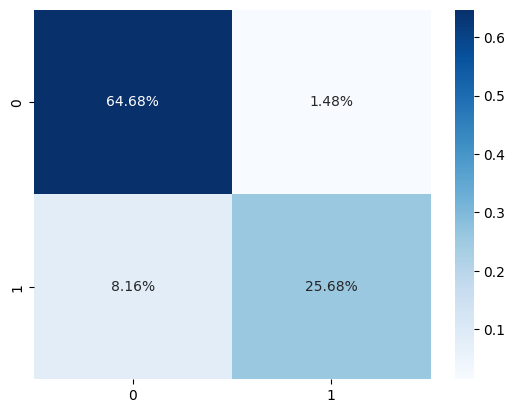

In [12]:
import seaborn as sns

cf_matrix = confusion_matrix(y_true, y_preds)
sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, fmt=".2%", cmap="Blues")